# Analyze phases

In this notebook we analyze the length of the phases and the number of stale/clean/renewed pages per phase.

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
year = 2018
folder = "start_stations"
n = 75000

In [65]:
def get_data(folder, year, month, n, k):
    pages = pd.read_csv(f"{folder}/{year}{month:02d}-citibike-stations.csv", header=None)[0].head(n)
    warmed_up_cache = set(pages.unique()[:k])
    rounds_per_page = compute_rounds_per_page(list(pages))
    return pages, warmed_up_cache, rounds_per_page

def compute_rounds_per_page(pages: list):
    rounds_per_page = {}
    for round, page in enumerate(pages):
        if page in rounds_per_page:
            rounds_per_page[page].append(round) # sorted list of rounds
        else:
            rounds_per_page[page] = [round]
    return rounds_per_page

In [66]:
def get_phases(month, k):
    pages, warmed_up_cache, rounds_per_page = get_data(folder, year, month, n, k)
    phases = []
    cache = set()
    clean = set()
    stale = set()
    renewed = set()

    for round, page in enumerate(pages):
        if len(cache) == k:
            phases.append([round, len(stale), len(clean), len(renewed)])
            stale = cache
            clean = set()
            renewed = set()
            cache = set()
        
        if page not in stale:
            clean.add(page)
        else:
            renewed.add(page)
        cache.add(page)
    
    phases.append([round, len(stale), len(clean), len(renewed)])
    return pd.DataFrame(phases, columns=['round', 'stale', 'clean', 'renewed'])

In [67]:
def mean_std(df):
    ratios = df['renewed'] / (df['clean'] + df['renewed'])
    ratios = ratios.to_numpy()[1:]
    return ratios.mean(), ratios.std()

dfs = []
for month in range(1, 13):
    df = get_phases(month, 500)
    df['month'] = month
    df['ratio'] = df['renewed'] / (df['clean'] + df['renewed'])
    dfs.append(df.drop(0))
    mean, std = mean_std(df)
    print(f"{month}: {mean:.5f} ± {std:.5f}")

df = pd.concat(dfs, ignore_index=True)
df

1: 0.79014 ± 0.01548
2: 0.79015 ± 0.02050
3: 0.78372 ± 0.01687
4: 0.77751 ± 0.01526
5: 0.79236 ± 0.01457
6: 0.78698 ± 0.01367
7: 0.78173 ± 0.01890
8: 0.77512 ± 0.01974
9: 0.75477 ± 0.01239
10: 0.77768 ± 0.01893
11: 0.78647 ± 0.01325
12: 0.77464 ± 0.02001


,round,stale,clean,renewed,month,ratio
0,2950,500,103,397,1,0.794000
1,4582,500,99,401,1,0.802000
2,6255,500,105,395,1,0.790000
3,8151,500,109,391,1,0.782000
4,10044,500,98,402,1,0.804000
...,...,...,...,...,...,...
517,68640,500,103,397,12,0.794000
518,70477,500,101,399,12,0.798000
519,72587,500,111,389,12,0.778000
520,74483,500,100,400,12,0.800000


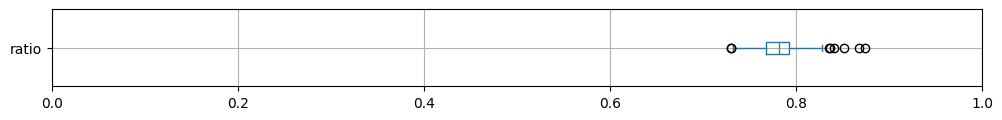

In [68]:
df['ratio'].plot(kind='box', vert=False, figsize=(12, 1), grid=True)
plt.xlim(0, 1)
plt.show()